In [65]:
### Installing the required packages 

!pip install pandas
!pip install quandl
!pip install matplotlib
!pip install yfinance
!pip install python-dotenv
!pip install requests
!pip install json

In [10]:
import pandas as pd 
import os
import quandl
import yfinance as yf
import matplotlib.pyplot as plt
import requests
import json
from datetime import date
from dotenv import load_dotenv


In [2]:
###loading the .env environment variables

load_dotenv()

True

In [3]:
## getting the environment variables
q_API_KEY = os.getenv('QUANDL_API_KEY')


In [4]:
## setting the API key
quandl.ApiConfig.api_key = q_API_KEY

In [5]:
## getting unemployment data during the gulf war

gulf_unemp_df = quandl.get(["FRED/UNRATE", "FRED/UNEMPLOY"], trim_start = "1990-02-1", trim_end="1991-02-28", collapse = 'monthly')
gulf_unemp_df.columns = ['Gulf_unemploy_rate', 'Gulf_unemploy_level']


gulf_unemp_df

,Gulf_unemploy_rate,Gulf_unemploy_level
Date,,
1990-02-28,5.3,6651.0
1990-03-31,5.2,6598.0
1990-04-30,5.4,6797.0
1990-05-31,5.4,6742.0
1990-06-30,5.2,6590.0
1990-07-31,5.5,6922.0
1990-08-31,5.7,7188.0
1990-09-30,5.9,7368.0
1990-10-31,5.9,7459.0


In [34]:
## getting unemployment data 6 months before the Russia Ukraine war from the Bureau of labour statistics

headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": ['LNS14000000'],"startyear":"2019", "endyear":"2022"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
json_data = json.loads(p.text)

data_list = []
for series in json_data['Results']['series']:
    
    seriesId = series['seriesID']
    
    data = series['data']
    
    for datum in data: 
        
        data = {'year':datum['year'],'month':datum['periodName'], 'value':datum['value']}
        data_list.append(data)
        
        
rus_unemp_df = pd.DataFrame(data_list)

rus_unemp_df

,year,month,value
0,2022,July,3.5
1,2022,June,3.6
2,2022,May,3.6
3,2022,April,3.6
4,2022,March,3.6
5,2022,February,3.8
6,2022,January,4.0
7,2021,December,3.9
8,2021,November,4.2
9,2021,October,4.6


In [35]:
## Creating the date column, renaming the value column and creating a dataframe with the date and unemployment rate columns only
rus_unemp_df['date'] = pd.to_datetime(rus_unemp_df['year']+"-"+rus_unemp_df['month']+"-"+"01")

rus_unemp_df.rename(columns = {'value': 'unemployment_rate'}, inplace= True)

rus_unemp_df = rus_unemp_df[['date', 'unemployment_rate']].copy()



In [36]:
## Filtering out the dates before 2021-09-1
mask = rus_unemp_df['date'] > '2021-09-1'
rus_final_df = rus_unemp_df[mask]

## Setting the date as the index for easy plotting. 
rus_final_df.set_index('date', inplace = True)

rus_final_df

,unemployment_rate
date,
2022-07-01,3.5
2022-06-01,3.6
2022-05-01,3.6
2022-04-01,3.6
2022-03-01,3.6
2022-02-01,3.8
2022-01-01,4.0
2021-12-01,3.9
2021-11-01,4.2


In [30]:
## function to graph data 
def plot_graph(df, title:str, y_label: str):
    
        ## graphing the data

    cols =[col for col in df.columns]

    fig,ax = plt.subplots(1,1, figsize = (14,6))
    plt.style.use('seaborn')

    for c in cols: 
        ax.plot(c, linewidth=2, data=df)
        ax.set_title(title)
        plt.xlabel('Date')
        plt.ylabel(y_label)

        handles,labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, loc='upper left', prop = {"size":10})

    plt.show()

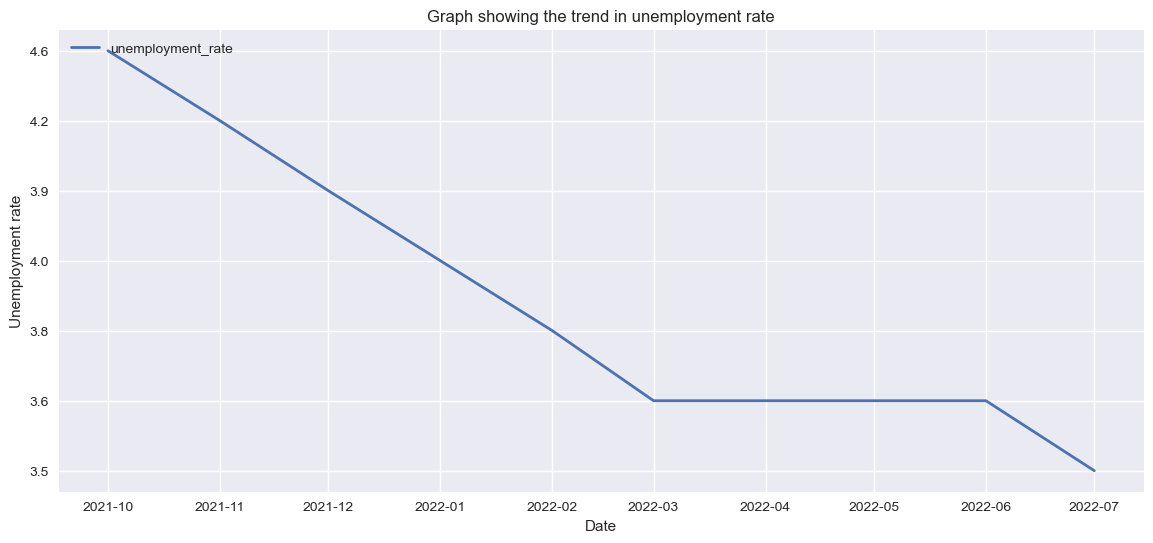

In [37]:
## graph showing the unemployment trend in from 6 months before the uk-russian invasion
plot_graph(rus_final_df, title="Graph showing the trend in unemployment rate", y_label="Unemployment rate")

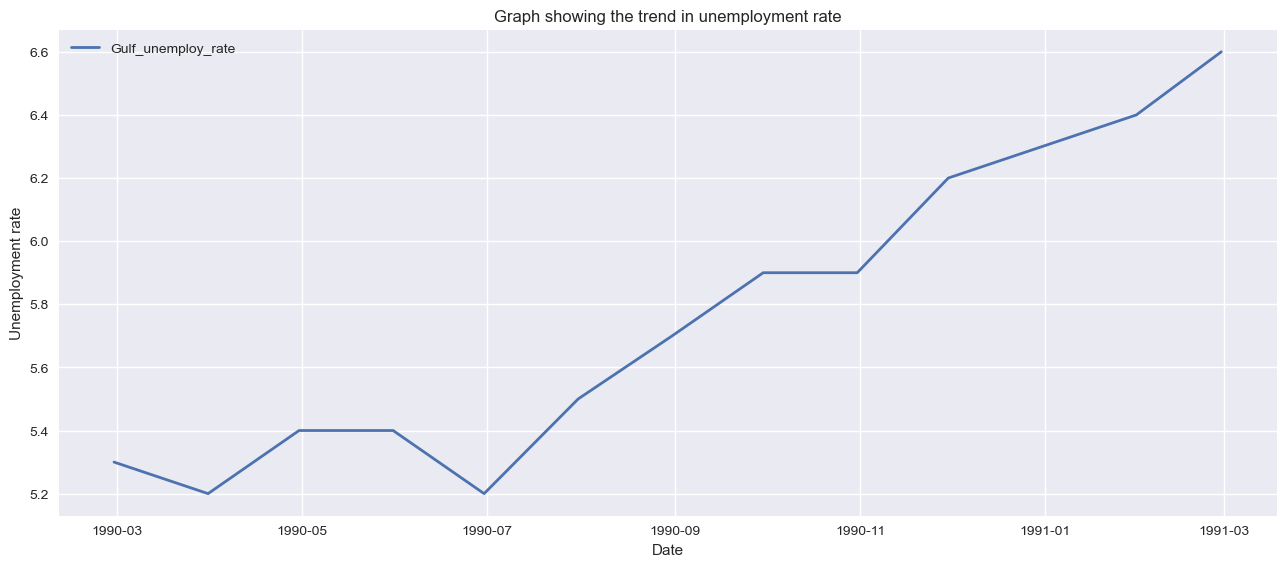

In [126]:
gulf_unemp_df = gulf_unemp_df[['Gulf_unemploy_rate']].copy()

plot_graph(gulf_unemp_df, title="Graph showing the trend in unemployment rate", y_label="Unemployment rate")

In [97]:
## function to fetch data from the yfinance

def exchange_data(start_date, end_date):
    
    tickers = ['LMT', 'BA', 'RTX', 'NOC', 'GD']

    ### looping through the tickers list to get their respective 'close' data during the gulf war period
    
    for id, ticker in enumerate(tickers):

        ## Getting the exchange object
        t_object = yf.Ticker(ticker)

        ## getting the data, cleaning it and reorganizing it. 
        hist = t_object.history(start=start_date, end=end_date)

        df = hist[['Close']].copy()

        df.rename(columns= {'Close': f"{ticker}_Close"}, inplace=True)

        df.reset_index(inplace=True)

        if id==0: 
            exchange_df = df
        else: 
            exchange_df = pd.merge(exchange_df, df, how="outer")
            
    return exchange_df

In [115]:
gulf_df = exchange_data("1990-02-01","1991-02-28")

## getting the current date for the  russian-ukraine invasion as it is not yet over
current_date_str = current_date.strftime("%Y-%m-%d")

rus_ukr_df = exchange_data("2021-09-01", current_date_str)

gulf_df.set_index('Date', inplace =True)

rus_ukr_df.set_index('Date', inplace=True)



,Date,LMT_Close,BA_Close,RTX_Close,NOC_Close,GD_Close
0,2021-08-31,352.205109,219.500000,83.302101,363.299561,195.828354
1,2021-09-01,349.131439,218.119995,82.653450,360.612122,195.319992
2,2021-09-02,350.492035,220.830002,83.085892,363.892365,197.773834
3,2021-09-03,348.485321,218.169998,82.211205,361.550720,197.930252
4,2021-09-07,341.828857,214.240005,81.572380,354.585114,197.861801
...,...,...,...,...,...,...
226,2022-07-26,396.809998,155.919998,90.239998,444.649994,217.630005
227,2022-07-27,398.540009,156.089996,90.269997,445.809998,219.850006
228,2022-07-28,406.079987,159.089996,92.389999,454.459991,223.800003
229,2022-07-29,413.809998,159.309998,93.209999,478.899994,226.669998


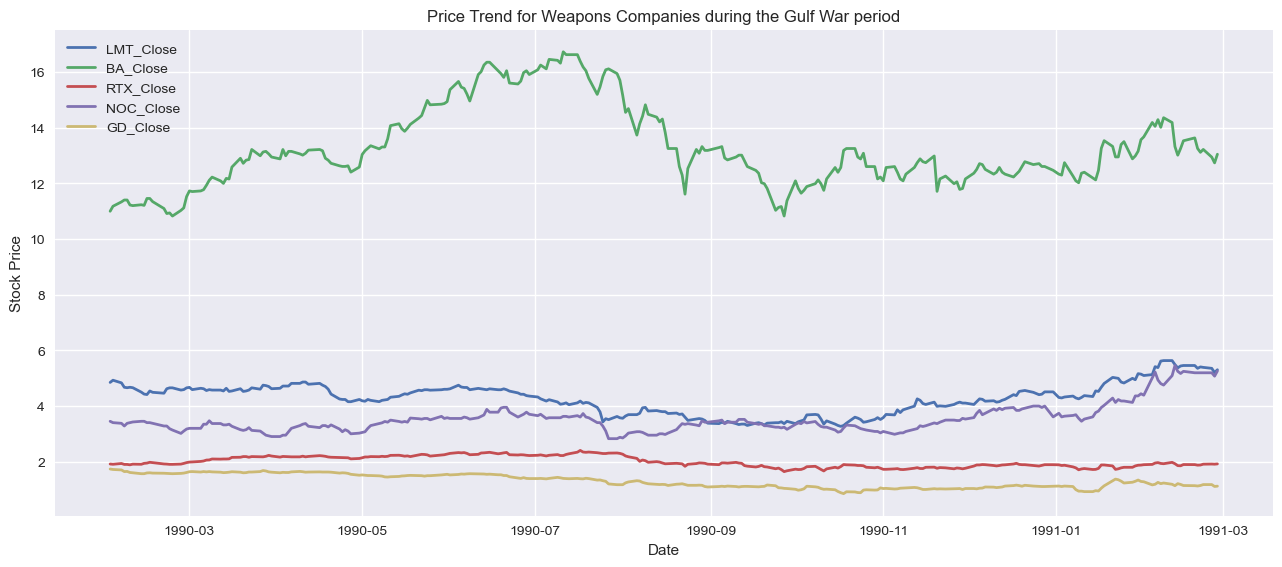

In [121]:
## graph showing the price trends for weapons Companies during the gulf War period
## LMT : Lockheed Martin Corp
## BA : Boeing
## RTX: Raytheon
## NOC: Northrop Grumman Corp
## GD: General Dynamics Corp
plot_graph(gulf_df, title="Price Trend for Weapons Companies during the Gulf War period", y_label="Stock Price")

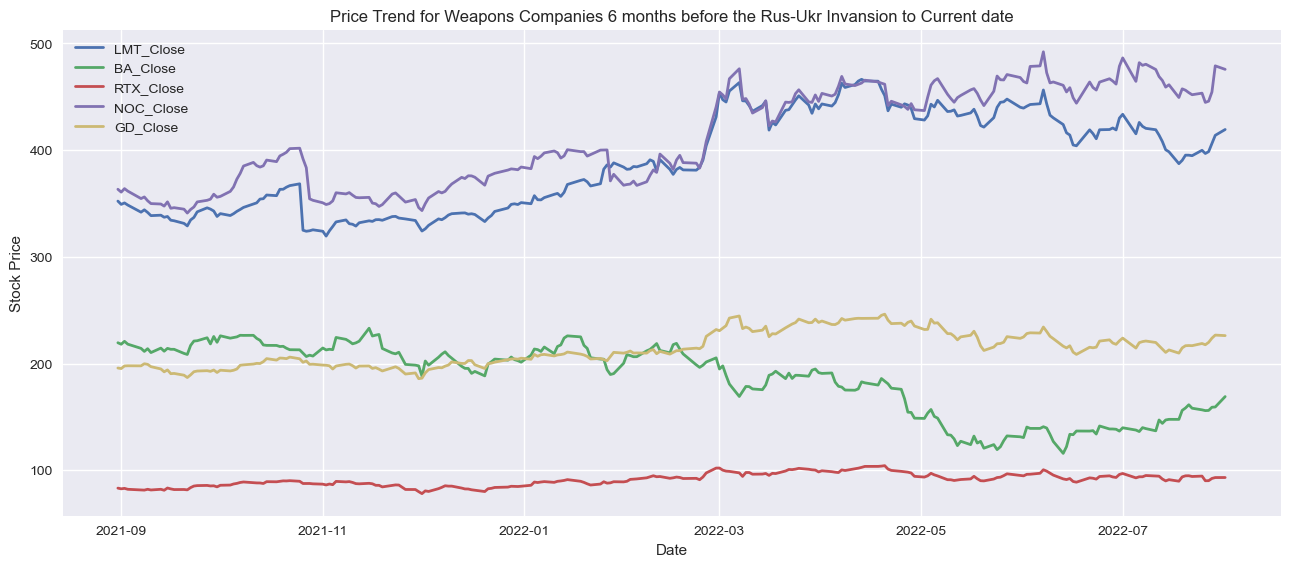

In [120]:
## graph showing the price trends for weapons Companies at the present time

plot_graph(rus_ukr_df, title="Price Trend for Weapons Companies 6 months before the Rus-Ukr Invansion to Current date", y_label="Stock Price" )